# Volpriehausen Formation Analysis: Data visualization

This notebook visualize poroperm data of Volprihausen Sandstone frome the NLOG poroperm data set

### Import Required Libraries and Read Shapefile
This section imports all necessary libraries and reads the shapefile from a nested ZIP archive.

In [32]:
import zipfile
import io
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

### Load poroperm data for Volpriehausen sandstone

In [33]:
# Borehole poroperm data
filename = r"poroperm_volpriehausen.xlsx"
borehole_data_raw = pd.read_excel(filename)

borehole_data_raw.columns

Index(['Unnamed: 0', 'NITG_NR', 'UWI', 'SHORT_NM', 'DEPTH', 'POROSITY',
       'HOR_PERMEABILITY', 'GRAIN_DENSITY', 'VERT_PERMEABILITY',
       'FORMATION_FACTOR', 'ANALYSIS_NR', 'CORE_NR', 'LAB', 'LAB_NR',
       'LAB_REPORT_DATE', 'REMARK', 'TOP_STRAT', 'BOTTOM_STRAT',
       'STRAT_UNIT_CD', 'STRAT_UNIT_NM', 'THICKNESS', 'LogK'],
      dtype='object')

### Calculate averages for each well

Each well has more than one sample. A mean value may be representative for each well.

In [34]:
borehole_data = borehole_data_raw.groupby('SHORT_NM')[['DEPTH', 'POROSITY', 'HOR_PERMEABILITY', 'VERT_PERMEABILITY', 'GRAIN_DENSITY', 'THICKNESS', 'LogK']].mean()

### Load geodata and merge Coordinates
This section loads borehole coordinates, then merges the poroperm data and creates a GeoDataFrame.

In [35]:
# Load map of the netherlands
with zipfile.ZipFile("NL_BE_DE.zip", "r") as zip_file:
    with zip_file.open("NL_BE_DE.geojson") as geojson_file:
        map = gpd.read_file(io.BytesIO(geojson_file.read()))

map = map.to_crs("EPSG:3857")

# Boreholes with coordinates provided by NLOG
filename = r"boreholes(1).xlsx"
borehole_coords = pd.read_excel(filename)
borehole_coords = borehole_coords[["Longitude WGS84", "Latitude WGS84", "Boorgatcode"]]

# Merge everything together
df = pd.merge(borehole_data, borehole_coords, left_on='SHORT_NM', right_on='Boorgatcode', how='left')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Longitude WGS84"], df["Latitude WGS84"]), crs='EPSG:4326')
gdf = gdf.to_crs("EPSG:3857")

print(gdf.columns)

Index(['DEPTH', 'POROSITY', 'HOR_PERMEABILITY', 'VERT_PERMEABILITY',
       'GRAIN_DENSITY', 'THICKNESS', 'LogK', 'Longitude WGS84',
       'Latitude WGS84', 'Boorgatcode', 'geometry'],
      dtype='object')


### Plot Maps
This section creates maps visualizing depth, grain density, log permeability, and porosity.

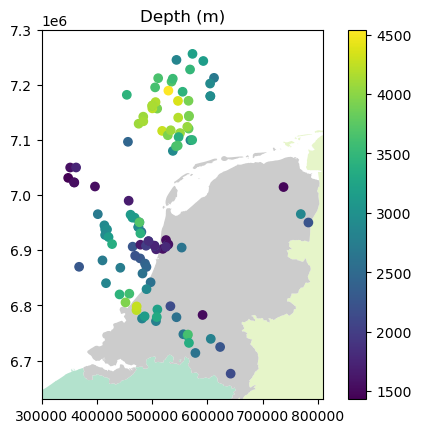

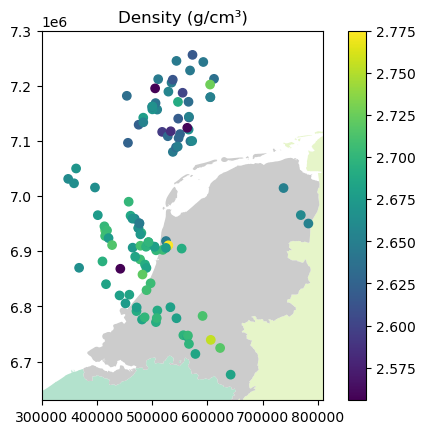

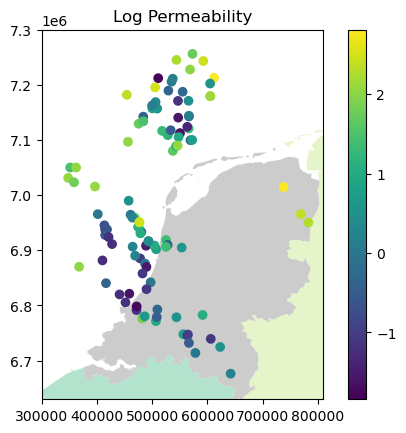

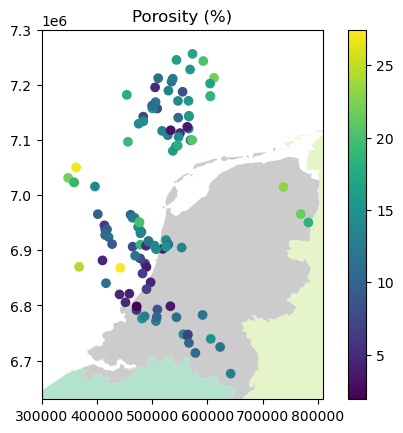

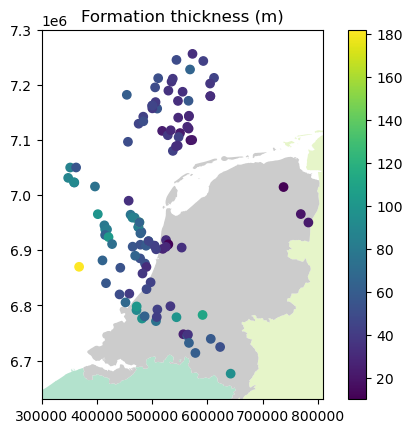

In [36]:
# Define map configurations
maps_config = [
    {"column": "DEPTH", "title": "Depth (m)"},
    {"column": "GRAIN_DENSITY", "title": "Density (g/cm³)"},
    {"column": "LogK", "title": "Log Permeability"},
    {"column": "POROSITY", "title": "Porosity (%)"},
    {"column": "THICKNESS", "title": "Formation thickness (m)"}
]

# Create maps in a loop
for config in maps_config:
    ax = map.plot(column='COUNTRY', cmap="Pastel2")
    gdf.plot(column=config["column"], legend=True, ax=ax)
    plt.title(config["title"])
    ax.set_xlim(0.3e6, 0.81e6)
    ax.set_ylim(0.663e7, 0.73e7)
    plt.show()

### Formation thickness

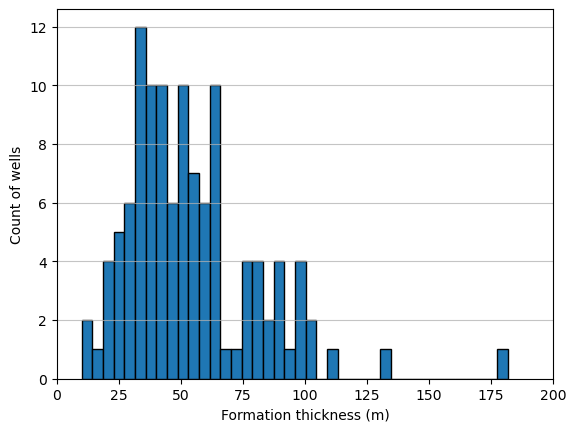

In [37]:
plt.hist(df.THICKNESS, bins=40, edgecolor='black')
plt.xlabel('Formation thickness (m)')
plt.ylabel('Count of wells')
plt.xlim([0, 200])
plt.grid(axis='y', alpha=0.75)
plt.show()

### Scatter Plot: Porosity vs. Log Permeability
This section creates a scatter plot of porosity versus the logarithm of horizontal permeability, colored by grain density.

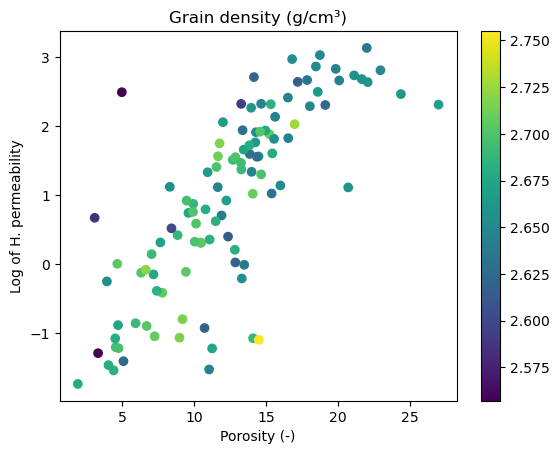

In [38]:
plt.scatter(df.POROSITY, np.log10(df.HOR_PERMEABILITY), marker='o', c=df.GRAIN_DENSITY.values)
plt.xlabel("Porosity (-)")
plt.ylabel("Log of H. permeability")
plt.title("Grain density (g/cm³)")
plt.colorbar()

### Remove Outliers and Visualize Data
This section removes outliers from the data and creates several scatter and plot visualizations.

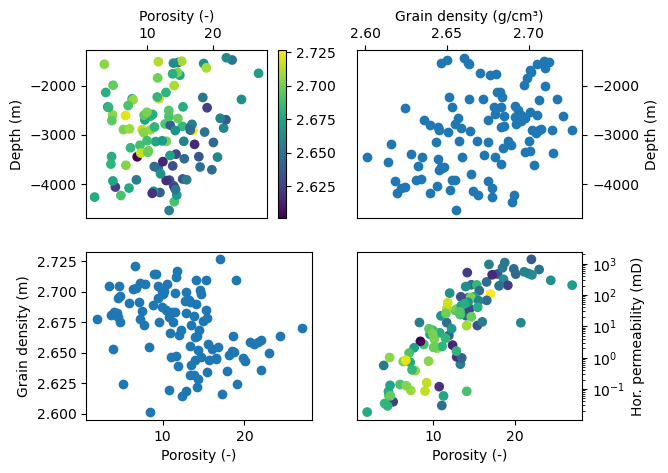

In [39]:
# Remove outliers
df.drop(df[df.GRAIN_DENSITY > 2.75].index, inplace=True)
df.drop(df[df.GRAIN_DENSITY < 2.6].index, inplace=True)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

im = ax1.scatter(df.POROSITY, -df.DEPTH, marker='o', c=df.GRAIN_DENSITY.values)
ax1.set_xlabel("Porosity (-)")
ax1.set_ylabel("Depth (m)")
ax1.xaxis.set_label_position("top")
ax1.xaxis.tick_top()
plt.colorbar(im, ax=ax1)

ax2.plot(df.GRAIN_DENSITY, -df.DEPTH, 'o')
ax2.set_xlabel("Grain density (g/cm³)")
ax2.set_ylabel("Depth (m)")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position("top")
ax2.xaxis.tick_top()

ax3.plot(df.POROSITY, df.GRAIN_DENSITY, 'o')
ax3.set_xlabel("Porosity (-)")
ax3.set_ylabel("Grain density (m)")

ax4.scatter(df.POROSITY, df.HOR_PERMEABILITY, marker='o', c=df.GRAIN_DENSITY.values)
ax4.set_yscale('log')
ax4.set_xlabel("Porosity (-)")
ax4.set_ylabel("Hor. permeability (mD)")
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()

### Plot Logarithmic Histogram of Permeability
This section defines a function to plot histograms with logarithmic bins and visualizes horizontal permeability for different grain density ranges.

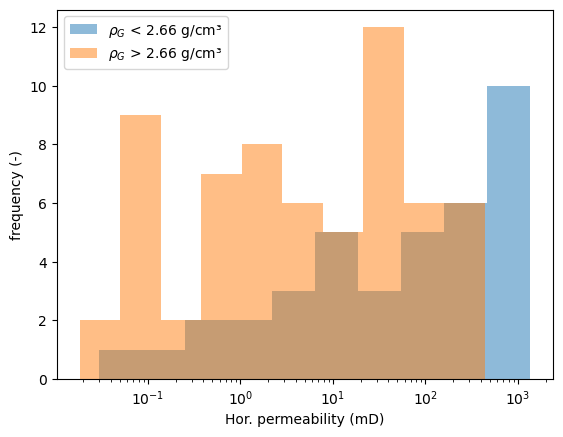

In [40]:
def plot_loghist(x, bins, label):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins, alpha=0.5, label=label)
  plt.xscale('log')

plot_loghist(df.HOR_PERMEABILITY[df.GRAIN_DENSITY < 2.66], 10, label=r"$\rho_G$ < 2.66 g/cm³")
plot_loghist(df.HOR_PERMEABILITY[df.GRAIN_DENSITY > 2.66].dropna(), 10, label=r"$\rho_G$ > 2.66 g/cm³")
plt.ylabel("frequency (-)")
plt.xlabel("Hor. permeability (mD)")
plt.legend()

### Plot Permeability vs. Depth (Log Scale)
This section visualizes horizontal permeability versus depth for different grain density ranges using a logarithmic y-axis.

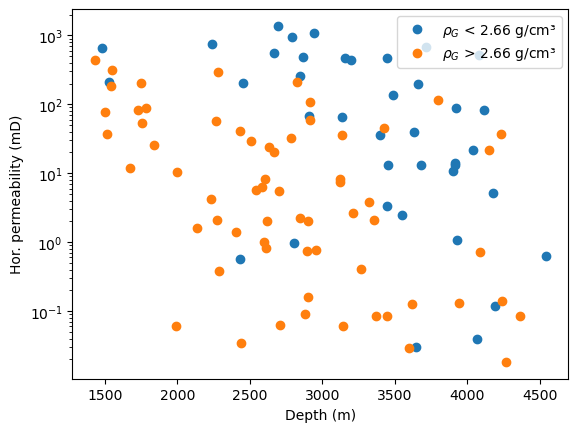

In [41]:
plt.semilogy(df.DEPTH[df.GRAIN_DENSITY < 2.66], df.HOR_PERMEABILITY[df.GRAIN_DENSITY < 2.66], 'o', label=r"$\rho_G$ < 2.66 g/cm³")
plt.semilogy(df.DEPTH[df.GRAIN_DENSITY > 2.66], df.HOR_PERMEABILITY[df.GRAIN_DENSITY > 2.66], 'o', label=r"$\rho_G$ > 2.66 g/cm³")
plt.xlabel("Depth (m)")
plt.ylabel("Hor. permeability (mD)")
plt.legend()

### Calculate and Plot Semivariogram for Porosity
This section defines a function to calculate the semivariogram and plots it for porosity.

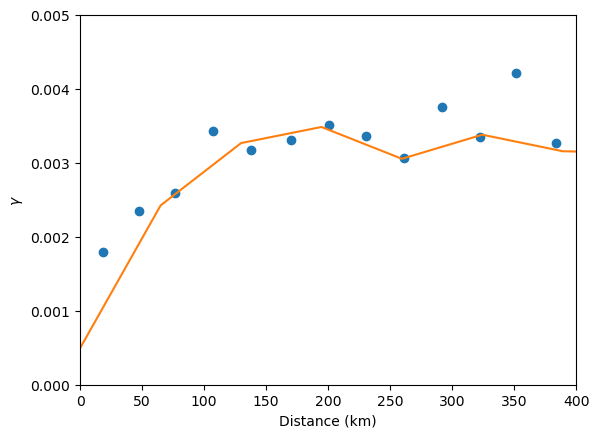

In [42]:
from itertools import combinations

def semivariogramm(df, column, nbins=20, logscale=False):
    # df: Geodataframe in a projected coordinate system such as UTM
    # column: String with column name
    # nbins: Number of bins for binning/averaging the calculated semi-variance values


    distance = list()
    var_value = list()

    for i, j in combinations(range(len(df)), 2):
        rowi = gdf.iloc[i]
        rowj = gdf.iloc[j]

        d = rowi.geometry.distance(rowj.geometry)

        if d < 1e8:
            vi = rowi[column]
            vj = rowj[column]

            if logscale:
                vi = np.log10(vi)
                vj = np.log10(vj)

            v = 0.5*((vi-vj)/100)**2

            if not np.isnan(v):
                distance.append(d/1000)  # m -> km
                var_value.append(v)

    distance = np.array(distance)
    var_value = np.array(var_value)

    dmin = min(distance)
    dmax = max(distance)

    d = np.linspace(dmin, dmax, nbins)

    dist = list()
    varp = list()

    for i in range(len(d)-1):

        ind = (distance > d[i]) & (distance < d[i+1])  

        dist.append(np.mean(distance[ind]))
        varp.append(np.mean(var_value[ind]))

    return dist, varp, dmin, dmax

dist, varp, dmin, dmax = semivariogramm(df, 'POROSITY')


plt.plot(dist, varp, 'o')
plt.xlabel("Distance (km)")
plt.ylabel("$\gamma$")

from scipy.interpolate import splrep, BSpline

tck = splrep(dist, varp, s=0)
xnew = np.linspace(dmin, dmax, 10)
plt.plot(xnew, BSpline(*tck)(xnew), '-', label='s=0')
plt.xlim(0, 400)
plt.ylim(0, 0.005)

plt.show()

### Calculate and Plot Semivariogram for Permeability
This section calculates and plots the semivariogram for horizontal permeability using a logarithmic scale.

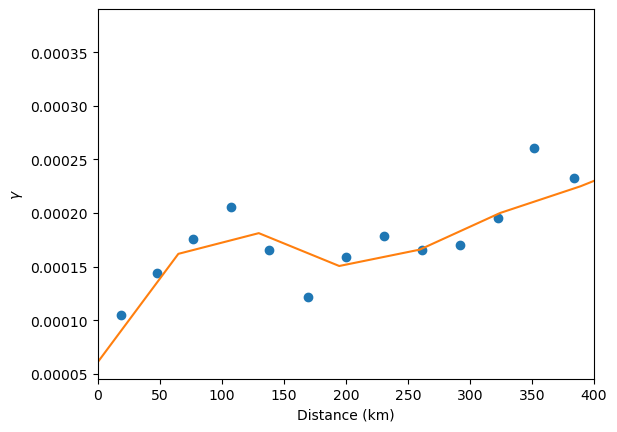

In [43]:
dist, varp, dmin, dmax = semivariogramm(df, 'HOR_PERMEABILITY', logscale=True)

plt.plot(dist, varp, 'o')
plt.xlabel("Distance (km)")
plt.ylabel("$\gamma$")

from scipy.interpolate import splrep, BSpline

tck = splrep(dist, varp, s=0)
xnew = np.linspace(dmin, dmax, 10)
plt.plot(xnew, BSpline(*tck)(xnew), '-', label='s=0')
plt.xlim(0, 400)
#plt.ylim(0, 0.005)

plt.show()

### Linear Regression and Residual Analysis
This section performs a linear regression between porosity and the logarithm of horizontal permeability, and analyzes the residuals.

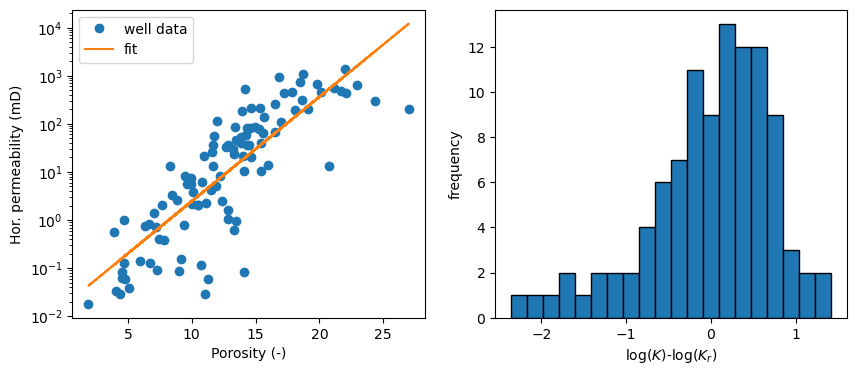

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df2 = df[["POROSITY", "HOR_PERMEABILITY"]].dropna()

# Example data
x = df2.POROSITY.values.reshape(-1, 1)
y = np.log10(df2.HOR_PERMEABILITY.values.reshape(-1, 1))

# Fit linear regression
model = LinearRegression()
model.fit(x, y)
y_r = model.predict(x)

# Calculate difference
diff = y - y_r

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)

# Plot histogram
ax2.hist(diff, bins=20, edgecolor='black')
ax2.set(xlabel = 'log($K$)-log($K_r$)')
ax2.set(ylabel = 'frequency')


ax1.semilogy(df.POROSITY, df.HOR_PERMEABILITY, 'o', label="well data")
ax1.semilogy(x, 10**y_r, label="fit")
ax1.set(xlabel = "Porosity (-)")
ax1.set(ylabel = "Hor. permeability (mD)")
ax1.legend()

plt.show()